<a href="https://colab.research.google.com/github/dgambone3/CSC6850_Machine_Learning_Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
### Run once to download dataset directly from Kaggle ###
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp /kaggle.json ~/.kaggle/
# ! chmod 600 ~/kaggle.json
# ! kaggle datasets download alexteboul/diabetes-health-indicators-dataset
# ! unzip diabetes-health-indicators-dataset.zip
                          

In [38]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import numpy as np

# metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


# processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate



# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# extra credit
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Diabetes Indicators Dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [40]:
X = df.iloc[:, 1:] # features
X = X.astype(int)
y = df.iloc[:, :1]
y = y.astype(int).values.ravel()

In [41]:
#### SPLIT FOR FASTER TESTING -  REMOVE FOR FINAL TESTS ####
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, 
                                                                        y, 
                                                                        train_size=0.10)

X55_train, X55_test, y55_train, y55_test = train_test_split(X_train_temp, 
                                                        y_train_temp, 
                                                        train_size=.5, 
                                                        test_size=.5, 
                                                        shuffle=True,
                                                       random_state=1234)
X73_train, X73_test, y73_train, y73_test = train_test_split(X_train_temp, 
                                                        y_train_temp, 
                                                        train_size=.7, 
                                                        test_size=.3, 
                                                        shuffle=True,
                                                       random_state=1234)
X82_train, X82_test, y82_train, y82_test = train_test_split(X_train_temp, 
                                                        y_train_temp, 
                                                        train_size=.8, 
                                                        test_size=.2, 
                                                        shuffle=True,
                                                       random_state=1234)

train = [(X55_train, y55_train), 
          (X73_train, y73_train), 
          (X82_train, y82_train)]
test = [(X55_test, y55_test),
          (X73_test, y73_test),
          (X82_test, y82_test)]
index = []
for i in range(1,11):
  index.append(f'Fold {i}')
train_colors = ['navy', 'green', 'firebrick']
test_colors = ['skyblue', 'palegreen', 'salmon']
# split55_df = pd.DataFrame(columns=['model','accuracy''precision', 'recall'],
#                        index=index)
# split73_df = pd.DataFrame(columns=['model','accuracy''precision', 'recall'],
#                        index=index)
# split82_df = pd.DataFrame(columns=['model','accuracy''precision', 'recall'],
#                        index=index)


In [42]:
### REQUIRED MODELS ###
# 1) Decision Tree/Random Forest
# 2) Perceptron
# 3) Naive Bayes
# 4) Logistic Regression
# 5) Linear Regression
# 6) SVM - Linear Kernel
# 7) SVM - RBF kernel
# 8) Gradient Boosting
# 9) Multi-layer Perceptron (MLP)
# # EXTRA CREDIT ##
# 10) Regularized Linear Regression (SGD)
# 11) Lasso
# 12) Polynomial Linear Reg
# 13) k-Nearest Neighbor

titles = ['Decision Tree',
          'Perceptron',
          'Naive Bayes',
          'Logistic Regression',
          'Linear Regression',
          'SVM - Linear',
          'SVM - RBF',
          'Gradient Boost',
          'Muti-Layer Perceptron',
          'Regularilized Linear Regression',
          'Lasso Linear Regression',
          'k-Nearest Neighbors',
          'Linear Regression with Optimal Polynomial']


models = [DecisionTreeClassifier(criterion='gini', splitter='best'),
          Perceptron(),
          GaussianNB(),
          LogisticRegression(solver='liblinear'), 
          LinearRegression(),
          LinearSVC(dual=False),
          SVC(kernel='rbf', decision_function_shape='ovr'),
          GradientBoostingClassifier(),
          MLPClassifier(max_iter=500, hidden_layer_sizes=10),
          SGDRegressor(loss='squared_error', penalty='l2'),
          Lasso(selection='random'),
          KNeighborsClassifier(weights='distance'),
          LinearRegression()]


splits = [(0.5, 0.5), 
          (0.7, 0.3),
          (0.8, 0.2)]

In [43]:
def get_acc_score(mod, X, y):
  pred = mod.predict(X)
  return accuracy_score(y_true=y, y_pred=np.around(pred))

def get_prec_score(mod, X, y):
  pred = mod.predict(X)
  return precision_score(y_true=y, y_pred=np.around(pred), average='weighted', zero_division=0)

def get_recall_score(mod, X, y):
  pred = mod.predict(X)
  return recall_score(y_true=y, y_pred=np.around(pred),average='weighted', zero_division=0)

def get_f1_score(mod, X, y):
  pred = mod.predict(X)
  return f1_score(y_true=y, y_pred=np.around(pred),average='weighted', zero_division=0)

def get_error_score(mod, X, y):
  pred = mod.predict(X)
  return MSE(y_true=y, y_pred=pred)




def get_learning_curve(model, X, y, title):
  scores=[]
  perc=[]
  for n in range(1,101):
    perc.append(n)
    XX = X.iloc[0:int(len(X) * (n/100))] #df
    yy = y[0:int(len(y) * (n/100))] #list
    pred = model.predict(XX)
    if 'Linear Regression' not in title:
      score = accuracy_score(y_true=yy, y_pred=pred)
    else:
      score = MSE(y_true=yy, y_pred=pred)
    scores.append(score)
  return pd.DataFrame({'percent':perc, 'scores':scores})


def best_poly(X_train, y_train, X_test, y_test):
  degree = [1, 2]
  z = []
  poly_df = pd.DataFrame(columns=['polynomial', 'score'])
  print('   Polynomial Scores')
  for deg in degree:
    linreg = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=deg,
                                             include_bias=False)
    lin_pipe = Pipeline([('scaler', StandardScaler()),
                        ("polynomial_features", polynomial_features),
                        ("linear_regression", linreg)])
    lin_pipe.fit(X,y)
    score = lin_pipe.score(X_test,y_test)
    z.append(score)
    print(f'Degree: {deg}  Score: {score}')
  p = z.index(max(z)) + 1
    
  return p



Decision Tree
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.768322,0.783654,0.768322,0.775737,0.231678
1,0.766745,0.773332,0.766745,0.769918,0.233255
2,0.759653,0.773952,0.759653,0.766576,0.240347
3,0.765957,0.779550,0.765957,0.772487,0.234043
4,0.780757,0.799616,0.780757,0.789681,0.219243
5,0.754732,0.762917,0.754732,0.758755,0.245268
6,0.762618,0.784888,0.762618,0.773229,0.237382
7,0.757886,0.775954,0.757886,0.766312,0.242114
8,0.753943,0.771573,0.753943,0.762368,0.246057
9,0.764196,0.785874,0.764196,0.774498,0.235804


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.748874,0.766692,0.748874,0.757580,0.251126
1,0.750000,0.791228,0.750000,0.768568,0.250000
2,0.777590,0.782683,0.777590,0.780024,0.222410
3,0.784910,0.790901,0.784910,0.787865,0.215090
4,0.752815,0.767663,0.752815,0.759987,0.247185
5,0.768581,0.781905,0.768581,0.775070,0.231419
6,0.783221,0.791289,0.783221,0.787151,0.216779
7,0.753239,0.773451,0.753239,0.762969,0.246761
8,0.762254,0.780909,0.762254,0.770913,0.237746
9,0.743662,0.772764,0.743662,0.757165,0.256338


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.766502,0.783050,0.766502,0.774417,0.233498
1,0.756158,0.772429,0.756158,0.763970,0.243842
2,0.760099,0.776634,0.760099,0.767929,0.239901
3,0.767980,0.779791,0.767980,0.773719,0.232020
4,0.761952,0.769008,0.761952,0.765430,0.238048
5,0.767866,0.777436,0.767866,0.772529,0.232134
6,0.753573,0.773714,0.753573,0.763141,0.246427
7,0.754066,0.774503,0.754066,0.763839,0.245934
8,0.762445,0.775536,0.762445,0.768827,0.237555
9,0.762445,0.774677,0.762445,0.768285,0.237555


Perceptron
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.817179,0.775629,0.817179,0.793240,0.182821
1,0.717100,0.800114,0.717100,0.749751,0.282900
2,0.729708,0.770490,0.729708,0.749320,0.270292
3,0.787234,0.791969,0.787234,0.786276,0.212766
4,0.787855,0.764043,0.787855,0.774019,0.212145
5,0.782334,0.782112,0.782334,0.778650,0.217666
6,0.790221,0.778373,0.790221,0.781724,0.209779
7,0.814669,0.764153,0.814669,0.779995,0.185331
8,0.783912,0.786756,0.783912,0.784942,0.216088
9,0.809148,0.792569,0.809148,0.799229,0.190852


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.811374,0.768778,0.811374,0.786576,0.188626
1,0.787162,0.776357,0.787162,0.781722,0.212838
2,0.788851,0.792384,0.788851,0.790073,0.211149
3,0.785473,0.798841,0.785473,0.790690,0.214527
4,0.803491,0.772634,0.803491,0.784971,0.196509
5,0.794482,0.778866,0.794482,0.786543,0.205518
6,0.782658,0.794035,0.782658,0.787450,0.217342
7,0.774648,0.793106,0.774648,0.783128,0.225352
8,0.784789,0.794371,0.784789,0.789491,0.215211
9,0.816338,0.778655,0.816338,0.793635,0.183662


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.813793,0.789971,0.813793,0.800935,0.186207
1,0.800493,0.750695,0.800493,0.770799,0.199507
2,0.770443,0.745497,0.770443,0.756238,0.229557
3,0.824631,0.777976,0.824631,0.795936,0.175369
4,0.791030,0.778085,0.791030,0.782919,0.208970
5,0.784623,0.774281,0.784623,0.778154,0.215377
6,0.766387,0.725495,0.766387,0.743480,0.233613
7,0.826516,0.763708,0.826516,0.781768,0.173484
8,0.817151,0.756593,0.817151,0.779617,0.182849
9,0.828980,0.787604,0.828980,0.804284,0.171020


Naive Bayes
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.755713,0.809473,0.755713,0.774879,0.244287
1,0.743893,0.805907,0.743893,0.766458,0.256107
2,0.733649,0.804582,0.733649,0.758274,0.266351
3,0.766745,0.832026,0.766745,0.784275,0.233255
4,0.752366,0.809646,0.752366,0.773250,0.247634
5,0.750000,0.806265,0.750000,0.770335,0.250000
6,0.727129,0.796666,0.727129,0.752421,0.272871
7,0.742114,0.810748,0.742114,0.765153,0.257886
8,0.742902,0.810526,0.742902,0.766708,0.257098
9,0.764196,0.816018,0.764196,0.781830,0.235804


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.743243,0.803900,0.743243,0.765364,0.256757
1,0.754505,0.819784,0.754505,0.776248,0.245495
2,0.747748,0.808512,0.747748,0.768054,0.252252
3,0.760698,0.816326,0.760698,0.779962,0.239302
4,0.730856,0.803500,0.730856,0.757085,0.269144
5,0.758446,0.817551,0.758446,0.778086,0.241554
6,0.746059,0.807746,0.746059,0.768610,0.253941
7,0.738028,0.807688,0.738028,0.763152,0.261972
8,0.740845,0.808654,0.740845,0.764990,0.259155
9,0.753803,0.814345,0.753803,0.774739,0.246197


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.750739,0.815138,0.750739,0.772671,0.249261
1,0.744335,0.805266,0.744335,0.766442,0.255665
2,0.756650,0.812872,0.756650,0.776549,0.243350
3,0.744335,0.798749,0.744335,0.764501,0.255665
4,0.752587,0.810098,0.752587,0.773613,0.247413
5,0.741252,0.806216,0.741252,0.764815,0.258748
6,0.758995,0.813196,0.758995,0.778830,0.241005
7,0.734352,0.795470,0.734352,0.757504,0.265648
8,0.744209,0.809058,0.744209,0.767720,0.255791
9,0.753080,0.809065,0.753080,0.773217,0.246920


Logistic Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.850276,0.806463,0.850276,0.807686,0.149724
1,0.840032,0.784499,0.840032,0.794837,0.159968
2,0.846336,0.796163,0.846336,0.803347,0.153664
3,0.843972,0.791934,0.843972,0.800640,0.156028
4,0.850158,0.807902,0.850158,0.811117,0.149842
5,0.838328,0.784192,0.838328,0.797496,0.161672
6,0.846215,0.798684,0.846215,0.807542,0.153785
7,0.840694,0.791226,0.840694,0.803313,0.159306
8,0.838328,0.777596,0.838328,0.792402,0.161672
9,0.859621,0.826697,0.859621,0.821850,0.140379


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.840090,0.781964,0.840090,0.797434,0.159910
1,0.851914,0.809389,0.851914,0.814133,0.148086
2,0.847973,0.801989,0.847973,0.806956,0.152027
3,0.847973,0.798292,0.847973,0.804350,0.152027
4,0.843468,0.790789,0.843468,0.801010,0.156532
5,0.845158,0.792173,0.845158,0.801392,0.154842
6,0.844032,0.792938,0.844032,0.802129,0.155968
7,0.847324,0.798997,0.847324,0.808982,0.152676
8,0.840563,0.786885,0.840563,0.800297,0.159437
9,0.856338,0.816507,0.856338,0.816538,0.143662


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.851232,0.808219,0.851232,0.812753,0.148768
1,0.842365,0.788677,0.842365,0.799858,0.157635
2,0.850246,0.808096,0.850246,0.813189,0.149754
3,0.846305,0.799660,0.846305,0.804139,0.153695
4,0.843273,0.792298,0.843273,0.801519,0.156727
5,0.840315,0.786842,0.840315,0.799419,0.159685
6,0.847215,0.802658,0.847215,0.805185,0.152785
7,0.836865,0.783842,0.836865,0.798396,0.163135
8,0.845244,0.797990,0.845244,0.806251,0.154756
9,0.848694,0.802845,0.848694,0.807336,0.151306


Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.715524,0.767683,0.715524,0.737192,0.411472
1,0.710008,0.736123,0.710008,0.719610,0.445490
2,0.694247,0.768716,0.694247,0.726919,0.417142
3,0.706856,0.923430,0.706856,0.740812,0.407944
4,0.738959,0.819768,0.738959,0.775760,0.356346
5,0.708991,0.758936,0.708991,0.730028,0.429712
6,0.706625,0.770321,0.706625,0.733809,0.424435
7,0.692429,0.756210,0.692429,0.719335,0.420717
8,0.694795,0.769406,0.694795,0.727200,0.430921
9,0.725552,0.779223,0.725552,0.746421,0.378595


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.719032,0.781495,0.719032,0.745254,0.387281
1,0.698761,0.778545,0.698761,0.733765,0.395916
2,0.724662,0.777787,0.724662,0.746917,0.394047
3,0.716216,0.757003,0.716216,0.732454,0.415643
4,0.699887,0.755563,0.699887,0.723845,0.433510
5,0.717905,0.925095,0.717905,0.751853,0.394622
6,0.723536,0.789103,0.723536,0.752545,0.394378
7,0.712113,0.765761,0.712113,0.734759,0.419380
8,0.692394,0.757365,0.692394,0.719727,0.428602
9,0.714930,0.775778,0.714930,0.739681,0.395133


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.680788,0.906018,0.680788,0.709788,0.436268
1,0.713300,0.778518,0.713300,0.741292,0.399359
2,0.697044,0.781879,0.697044,0.733948,0.391642
3,0.720197,0.783725,0.720197,0.746719,0.393007
4,0.708231,0.748232,0.708231,0.724132,0.430999
5,0.692459,0.917367,0.692459,0.725443,0.427551
6,0.726959,0.813602,0.726959,0.765943,0.363056
7,0.694924,0.756755,0.694924,0.720697,0.441573
8,0.690488,0.772954,0.690488,0.726499,0.406792
9,0.709709,0.772904,0.709709,0.735160,0.402991


SVM - Linear
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.851064,0.817830,0.851064,0.795027,0.148936
1,0.841608,0.776789,0.841608,0.781614,0.158392
2,0.844760,0.793784,0.844760,0.784687,0.155240
3,0.843972,0.789411,0.843972,0.787836,0.156028
4,0.848580,0.809492,0.848580,0.792376,0.151420
5,0.842271,0.783269,0.842271,0.789235,0.157729
6,0.843060,0.783136,0.843060,0.788849,0.156940
7,0.847003,0.801928,0.847003,0.794170,0.152997
8,0.843060,0.781982,0.843060,0.783874,0.156940
9,0.850158,0.815077,0.850158,0.797289,0.149842


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.845158,0.789473,0.845158,0.788736,0.154842
1,0.848536,0.805199,0.848536,0.794744,0.151464
2,0.847973,0.807852,0.847973,0.789397,0.152027
3,0.846847,0.792886,0.846847,0.790116,0.153153
4,0.843468,0.783565,0.843468,0.785843,0.156532
5,0.845721,0.790146,0.845721,0.789526,0.154279
6,0.847410,0.798911,0.847410,0.793670,0.152590
7,0.848451,0.797107,0.848451,0.797552,0.151549
8,0.843944,0.784609,0.843944,0.789492,0.156056
9,0.851268,0.812618,0.851268,0.797456,0.148732


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.848768,0.809320,0.848768,0.792950,0.151232
1,0.843350,0.786989,0.843350,0.786572,0.156650
2,0.845813,0.800167,0.845813,0.791361,0.154187
3,0.845813,0.801648,0.845813,0.787164,0.154187
4,0.845244,0.794107,0.845244,0.788796,0.154756
5,0.842780,0.788570,0.842780,0.787311,0.157220
6,0.845737,0.801342,0.845737,0.789856,0.154263
7,0.841301,0.781440,0.841301,0.788929,0.158699
8,0.845737,0.798043,0.845737,0.793464,0.154263
9,0.846230,0.799420,0.846230,0.791169,0.153770


SVM - RBF
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.848700,0.806913,0.848700,0.794448,0.151300
1,0.844760,0.793723,0.844760,0.785930,0.155240
2,0.847912,0.805810,0.847912,0.790482,0.152088
3,0.847912,0.806852,0.847912,0.792574,0.152088
4,0.852524,0.820624,0.852524,0.799632,0.147476
5,0.848580,0.807895,0.848580,0.793156,0.151420
6,0.847792,0.800928,0.847792,0.792901,0.152208
7,0.847003,0.803234,0.847003,0.791935,0.152997
8,0.845426,0.794252,0.845426,0.786493,0.154574
9,0.852524,0.818841,0.852524,0.804077,0.147476


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.846284,0.794326,0.846284,0.791896,0.153716
1,0.849662,0.806474,0.849662,0.797968,0.150338
2,0.846284,0.792431,0.846284,0.787884,0.153716
3,0.846284,0.794343,0.846284,0.791082,0.153716
4,0.844032,0.784672,0.844032,0.782616,0.155968
5,0.844032,0.782455,0.844032,0.786820,0.155968
6,0.848536,0.802708,0.848536,0.792913,0.151464
7,0.852394,0.814675,0.852394,0.797689,0.147606
8,0.845070,0.788571,0.845070,0.790178,0.154930
9,0.852958,0.815220,0.852958,0.803176,0.147042


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.848768,0.807015,0.848768,0.796932,0.151232
1,0.844828,0.793349,0.844828,0.793720,0.155172
2,0.848276,0.805732,0.848276,0.797781,0.151724
3,0.847291,0.801874,0.847291,0.792024,0.152709
4,0.846230,0.798417,0.846230,0.790126,0.153770
5,0.843765,0.789149,0.843765,0.786037,0.156235
6,0.847708,0.808716,0.847708,0.791950,0.152292
7,0.848694,0.808386,0.848694,0.795505,0.151306
8,0.844258,0.792904,0.844258,0.791171,0.155742
9,0.847215,0.801427,0.847215,0.796537,0.152785


Gradient Boost
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.853428,0.813454,0.853428,0.815785,0.146572
1,0.847124,0.802055,0.847124,0.806846,0.152876
2,0.850276,0.805700,0.850276,0.811233,0.149724
3,0.851064,0.808495,0.851064,0.807636,0.148936
4,0.854101,0.816166,0.854101,0.815584,0.145899
5,0.838328,0.782426,0.838328,0.797041,0.161672
6,0.854890,0.816205,0.854890,0.822165,0.145110
7,0.843849,0.801517,0.843849,0.812479,0.156151
8,0.842271,0.787889,0.842271,0.798762,0.157729
9,0.855678,0.819447,0.855678,0.822302,0.144322


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.846847,0.797189,0.846847,0.806855,0.153153
1,0.853604,0.813738,0.853604,0.821183,0.146396
2,0.846284,0.797587,0.846284,0.806430,0.153716
3,0.854167,0.812731,0.854167,0.811826,0.145833
4,0.846284,0.797885,0.846284,0.805303,0.153716
5,0.851351,0.805658,0.851351,0.809609,0.148649
6,0.843468,0.794348,0.843468,0.805383,0.156532
7,0.855211,0.815117,0.855211,0.820630,0.144789
8,0.850704,0.807201,0.850704,0.813288,0.149296
9,0.853521,0.811035,0.853521,0.816811,0.146479


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.851724,0.810652,0.851724,0.816254,0.148276
1,0.851724,0.808113,0.851724,0.814892,0.148276
2,0.847291,0.803654,0.847291,0.812446,0.152709
3,0.843350,0.792938,0.843350,0.804267,0.156650
4,0.847215,0.800817,0.847215,0.806076,0.152785
5,0.843765,0.794880,0.843765,0.804821,0.156235
6,0.850172,0.809249,0.850172,0.815375,0.149828
7,0.839330,0.786414,0.839330,0.799031,0.160670
8,0.849187,0.806247,0.849187,0.814043,0.150813
9,0.847708,0.802281,0.847708,0.810225,0.152292


Muti-Layer Perceptron
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.845548,0.794808,0.845548,0.803941,0.154452
1,0.845548,0.797734,0.845548,0.802250,0.154452
2,0.848700,0.803554,0.848700,0.806363,0.151300
3,0.845548,0.794609,0.845548,0.800778,0.154452
4,0.851735,0.811182,0.851735,0.813064,0.148265
5,0.842271,0.788146,0.842271,0.796452,0.157729
6,0.851735,0.810160,0.851735,0.813709,0.148265
7,0.847792,0.806274,0.847792,0.815889,0.152208
8,0.835174,0.774337,0.835174,0.791100,0.164826
9,0.847003,0.799592,0.847003,0.807261,0.152997


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.844032,0.789498,0.844032,0.798905,0.155968
1,0.853604,0.813602,0.853604,0.812889,0.146396
2,0.851351,0.807806,0.851351,0.810202,0.148649
3,0.849662,0.802729,0.849662,0.810013,0.150338
4,0.843468,0.791088,0.843468,0.799415,0.156532
5,0.845721,0.792843,0.845721,0.799591,0.154279
6,0.846847,0.799732,0.846847,0.808465,0.153153
7,0.849577,0.803550,0.849577,0.811014,0.150423
8,0.845634,0.793645,0.845634,0.801935,0.154366
9,0.848451,0.804202,0.848451,0.812164,0.151549


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.851232,0.809260,0.851232,0.812540,0.148768
1,0.847783,0.802223,0.847783,0.808050,0.152217
2,0.845320,0.797917,0.845320,0.808040,0.154680
3,0.846305,0.799339,0.846305,0.807628,0.153695
4,0.844751,0.795012,0.844751,0.802531,0.155249
5,0.843273,0.794095,0.843273,0.804477,0.156727
6,0.851158,0.811307,0.851158,0.811153,0.148842
7,0.843765,0.794651,0.843765,0.803666,0.156235
8,0.850172,0.807268,0.850172,0.808682,0.149828
9,0.843273,0.794444,0.843273,0.804359,0.156727


Regularilized Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.727344,0.768065,0.727344,0.743414,0.410718
1,0.706856,0.733556,0.706856,0.717029,0.448147
2,0.721828,0.766761,0.721828,0.741118,0.418898
3,0.706856,0.922591,0.706856,0.740058,0.409082
4,0.735804,0.818705,0.735804,0.773529,0.357767
5,0.719243,0.758453,0.719243,0.735330,0.433950
6,0.701893,0.770673,0.701893,0.731721,0.424915
7,0.656151,0.756306,0.656151,0.697621,0.426014
8,0.688486,0.767966,0.688486,0.723025,0.433576
9,0.702681,0.770716,0.702681,0.730554,0.380282


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.728041,0.778476,0.728041,0.748839,0.388462
1,0.730856,0.764163,0.730856,0.745184,0.404559
2,0.725788,0.783509,0.725788,0.750385,0.394316
3,0.716216,0.753773,0.716216,0.731410,0.418988
4,0.703266,0.754826,0.703266,0.725347,0.435783
5,0.699887,0.930736,0.699887,0.744130,0.396476
6,0.689189,0.795406,0.689189,0.735649,0.401836
7,0.700845,0.766298,0.700845,0.728810,0.422091
8,0.716620,0.747396,0.716620,0.728780,0.429513
9,0.724507,0.763955,0.724507,0.739775,0.399783


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.678325,0.908196,0.678325,0.709631,0.438204
1,0.723645,0.772161,0.723645,0.744480,0.400127
2,0.719212,0.774837,0.719212,0.743552,0.395189
3,0.714778,0.782244,0.714778,0.743272,0.393895
4,0.706259,0.745654,0.706259,0.721877,0.433255
5,0.724495,0.909852,0.724495,0.739912,0.430416
6,0.680631,0.817449,0.680631,0.740692,0.378133
7,0.707245,0.752772,0.707245,0.725841,0.443601
8,0.693938,0.774294,0.693938,0.728811,0.407576
9,0.719073,0.768364,0.719073,0.738491,0.405231


Lasso Linear Regression
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.843184,0.710959,0.843184,0.771446,0.493154
1,0.822695,0.676827,0.822695,0.742666,0.528281
2,0.843184,0.710959,0.843184,0.771446,0.500743
3,0.846336,0.716284,0.846336,0.775898,0.489978
4,0.879338,0.773235,0.879338,0.822880,0.401976
5,0.835962,0.698833,0.835962,0.761271,0.509689
6,0.845426,0.714745,0.845426,0.774612,0.490614
7,0.832019,0.692255,0.832019,0.755730,0.501803
8,0.843060,0.710750,0.843060,0.771272,0.497271
9,0.840694,0.706766,0.840694,0.767935,0.477357


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.853041,0.727678,0.853041,0.785388,0.448556
1,0.840653,0.706698,0.840653,0.767877,0.486193
2,0.847973,0.719058,0.847973,0.778213,0.473659
3,0.835586,0.698203,0.835586,0.760742,0.499203
4,0.836712,0.700086,0.836712,0.762326,0.513725
5,0.856419,0.733453,0.856419,0.790181,0.463436
6,0.858671,0.737316,0.858671,0.793380,0.455758
7,0.841690,0.708442,0.841690,0.769339,0.494118
8,0.832113,0.692412,0.832113,0.755861,0.513146
9,0.841690,0.708442,0.841690,0.769339,0.479149


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.821182,0.674340,0.821182,0.740552,0.541512
1,0.846305,0.716233,0.846305,0.775855,0.474224
2,0.844335,0.712902,0.844335,0.773072,0.476192
3,0.849754,0.722081,0.849754,0.780732,0.469310
4,0.828487,0.686391,0.828487,0.750774,0.518390
5,0.837851,0.701995,0.837851,0.763930,0.515720
6,0.873829,0.763578,0.873829,0.814992,0.415475
7,0.834401,0.696225,0.834401,0.759076,0.517138
8,0.844258,0.712772,0.844258,0.772963,0.479931
9,0.838344,0.702821,0.838344,0.764624,0.490602


k-Nearest Neighbors
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.829787,0.781444,0.829787,0.798875,0.170213
1,0.828211,0.777584,0.828211,0.795564,0.171789
2,0.819543,0.769018,0.819543,0.788080,0.180457
3,0.817967,0.769836,0.817967,0.789559,0.182033
4,0.836751,0.793289,0.836751,0.808905,0.163249
5,0.827287,0.781269,0.827287,0.798073,0.172713
6,0.824132,0.779341,0.824132,0.797014,0.175868
7,0.813880,0.769929,0.813880,0.788428,0.186120
8,0.832019,0.784501,0.832019,0.800679,0.167981
9,0.828076,0.777757,0.828076,0.795115,0.171924


(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.824887,0.778843,0.824887,0.797266,0.175113
1,0.824324,0.786024,0.824324,0.799321,0.175676
2,0.825450,0.776993,0.825450,0.795543,0.174550
3,0.824887,0.782106,0.824887,0.799156,0.175113
4,0.811374,0.762483,0.811374,0.782863,0.188626
5,0.826577,0.773930,0.826577,0.793873,0.173423
6,0.826577,0.781915,0.826577,0.799267,0.173423
7,0.835493,0.796845,0.835493,0.808811,0.164507
8,0.818028,0.766765,0.818028,0.787316,0.181972
9,0.832676,0.784070,0.832676,0.800815,0.167324


(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.823645,0.783181,0.823645,0.799400,0.176355
1,0.816256,0.771946,0.816256,0.790257,0.183744
2,0.824138,0.786093,0.824138,0.800068,0.175862
3,0.821182,0.772089,0.821182,0.790971,0.178818
4,0.830951,0.787871,0.830951,0.803489,0.169049
5,0.820601,0.773039,0.820601,0.791180,0.179399
6,0.819616,0.772851,0.819616,0.791363,0.180384
7,0.824544,0.782493,0.824544,0.797132,0.175456
8,0.822080,0.776589,0.822080,0.794303,0.177920
9,0.824544,0.779571,0.824544,0.794670,0.175456


Linear Regression with Optimal Polynomial
   Polynomial Scores
Degree: 1  Score: 0.174302855248479
Degree: 2  Score: 0.20454456052211423
(0.5, 0.5)




,accuracy,precision,recall,f1_score,error
0,0.722616,0.887021,0.722616,0.748518,0.403254
1,0.714736,0.730156,0.714736,0.719266,0.443714
2,0.701340,0.911964,0.701340,0.733074,0.416055
3,0.721828,0.828323,0.721828,0.749336,0.393030
4,0.743691,0.873236,0.743691,0.778529,0.352618
5,0.714511,0.824000,0.714511,0.736832,0.426277
6,0.711356,0.851975,0.711356,0.741576,0.412534
7,0.689274,0.840978,0.689274,0.720617,0.420960
8,0.706625,0.856621,0.706625,0.735031,0.437410
9,0.729495,0.911809,0.729495,0.752024,0.373617


   Polynomial Scores
Degree: 1  Score: 0.18016192738461623
Degree: 2  Score: 0.2112292076707225
(0.7, 0.3)




,accuracy,precision,recall,f1_score,error
0,0.728604,0.907215,0.728604,0.753820,0.375491
1,0.715653,0.880152,0.715653,0.746351,0.390851
2,0.724662,0.857854,0.724662,0.749983,0.389015
3,0.729167,0.862786,0.729167,0.741782,0.405127
4,0.701577,0.900477,0.701577,0.724680,0.431200
5,0.724662,0.858045,0.724662,0.756395,0.383826
6,0.738739,0.857572,0.738739,0.764791,0.383755
7,0.707042,0.872528,0.707042,0.737076,0.408833
8,0.700282,0.834231,0.700282,0.728390,0.424572
9,0.718310,0.905637,0.718310,0.739926,0.396511


   Polynomial Scores
Degree: 1  Score: 0.16835334666980295
Degree: 2  Score: 0.19359770825538714
(0.8, 0.2)




,accuracy,precision,recall,f1_score,error
0,0.698522,0.892346,0.698522,0.725936,0.420158
1,0.721182,0.909467,0.721182,0.748451,0.387277
2,0.716749,0.883738,0.716749,0.748568,0.385803
3,0.719212,0.861843,0.719212,0.748172,0.389343
4,0.725973,0.871495,0.725973,0.736947,0.421071
5,0.698374,0.843250,0.698374,0.730137,0.418113
6,0.732873,0.858193,0.732873,0.770128,0.354388
7,0.714638,0.873413,0.714638,0.735532,0.428073
8,0.701824,0.858884,0.701824,0.737814,0.404556
9,0.715131,0.844375,0.715131,0.737314,0.402401


,model,split,error,generalization
0,Decision Tree,"(0.8, 0.2)",0.232020,0.530692
1,Perceptron,"(0.5, 0.5)",0.182821,0.606362
2,Naive Bayes,"(0.7, 0.3)",0.239302,0.514870
3,Logistic Regression,"(0.7, 0.3)",0.143662,0.705372
4,Linear Regression,"(0.7, 0.3)",0.387281,0.016840
5,SVM - Linear,"(0.7, 0.3)",0.148732,0.697937
6,SVM - RBF,"(0.5, 0.5)",0.147476,0.701467
7,Gradient Boost,"(0.7, 0.3)",0.144789,0.706085
8,Muti-Layer Perceptron,"(0.5, 0.5)",0.148265,0.699575
9,Regularilized Linear Regression,"(0.8, 0.2)",0.378133,0.012546


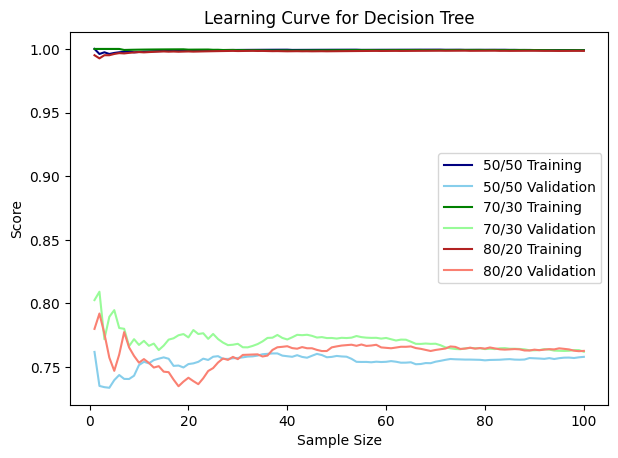

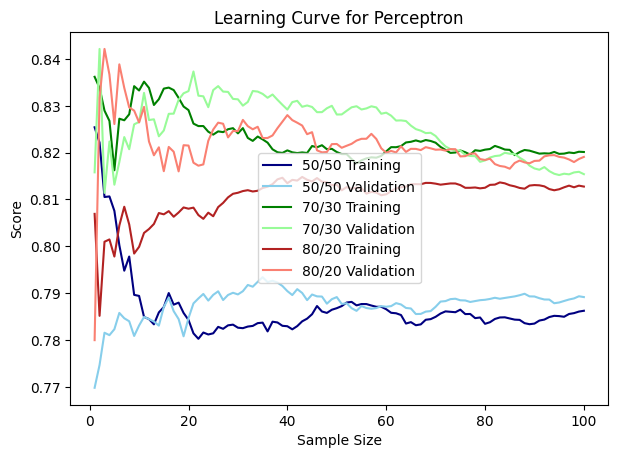

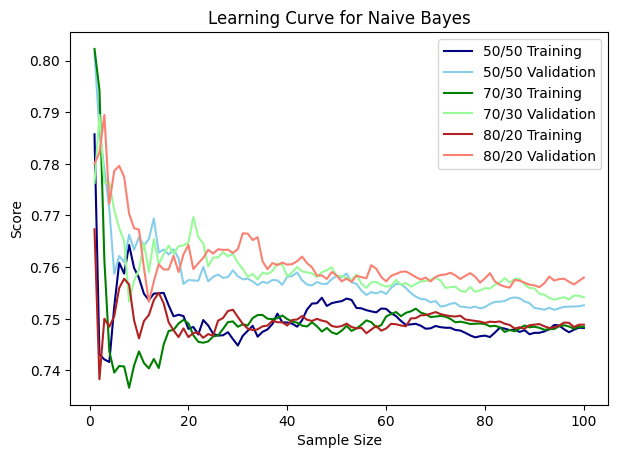

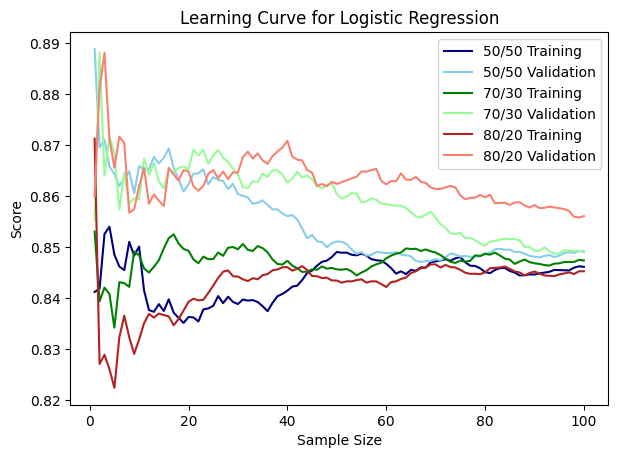

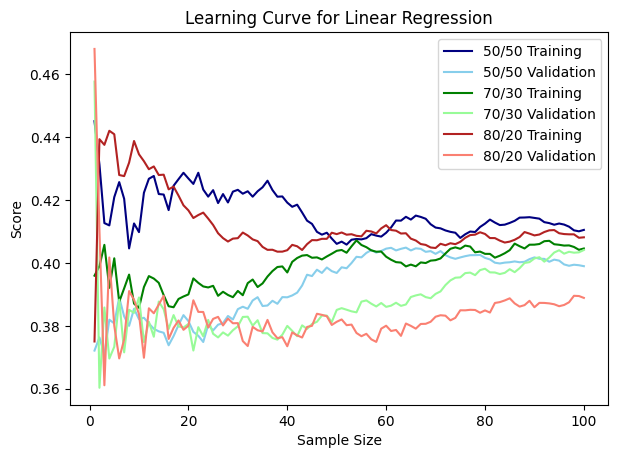

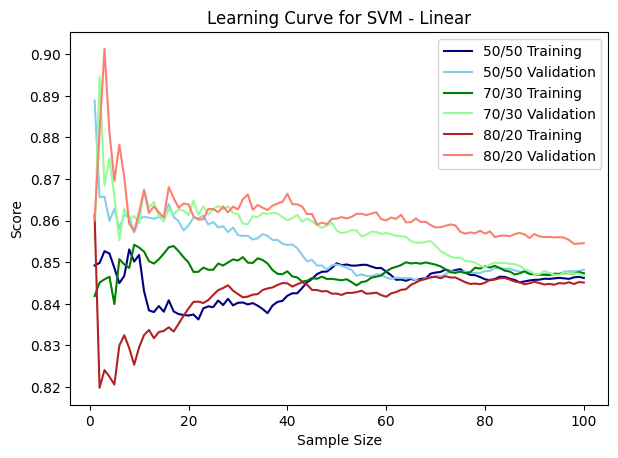

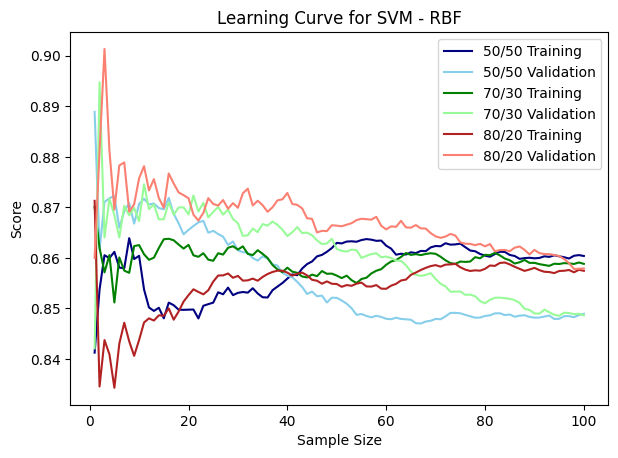

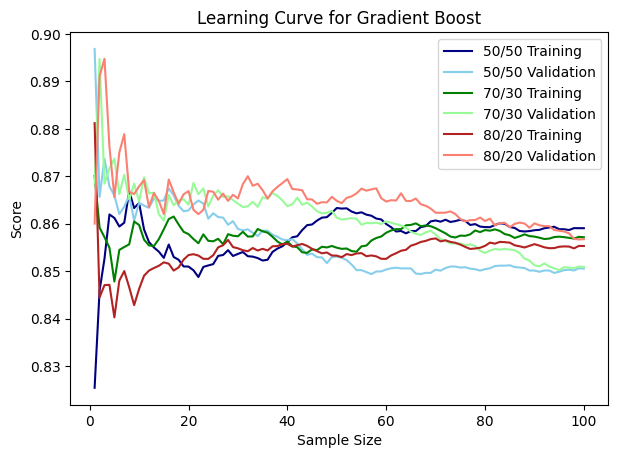

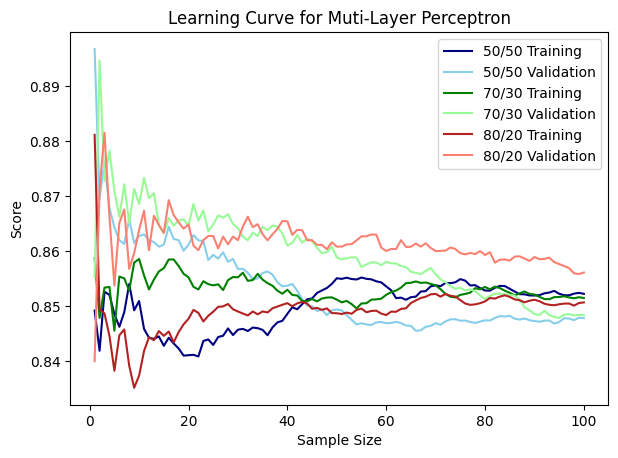

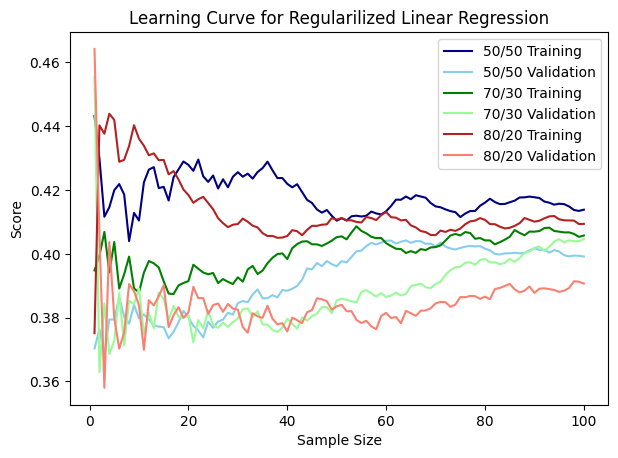

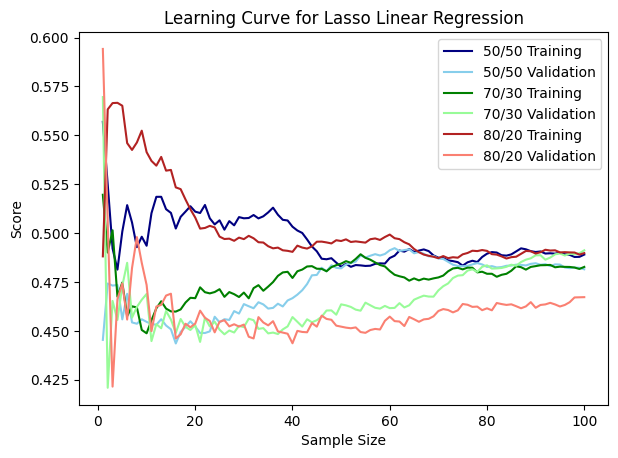

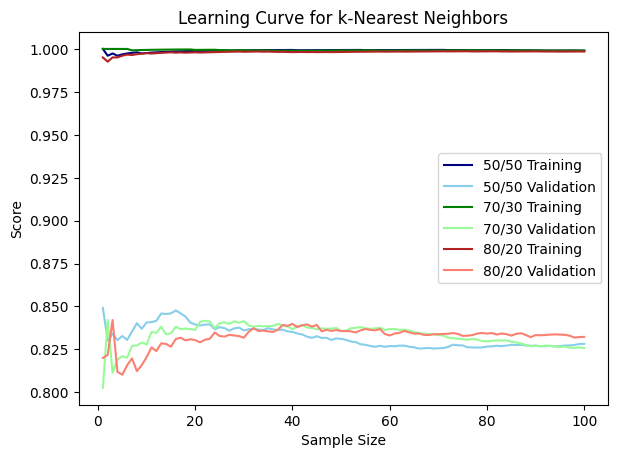

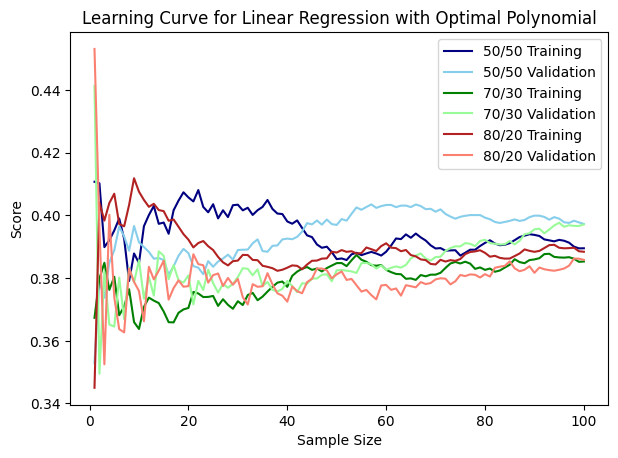

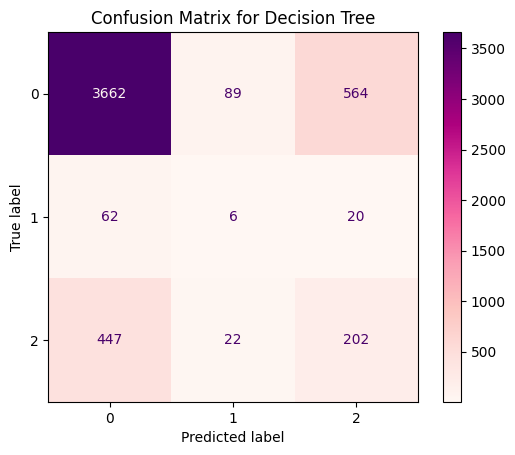

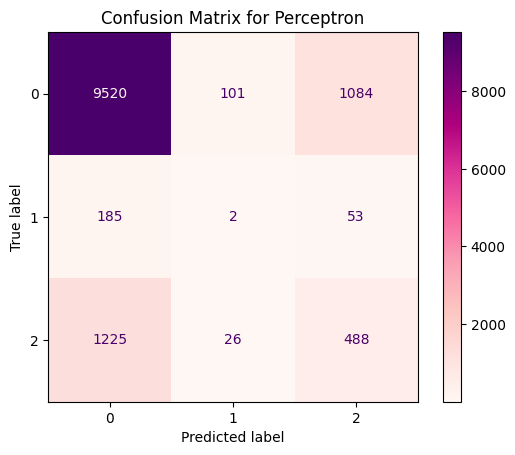

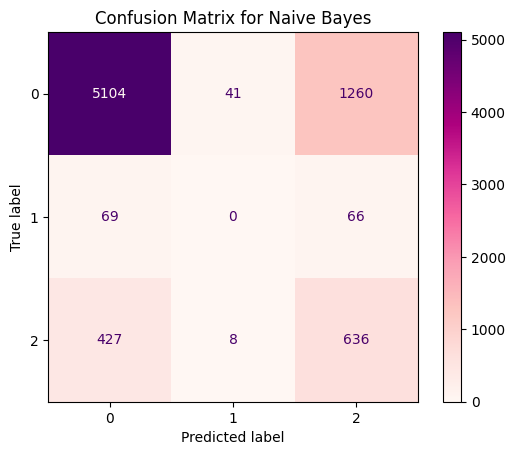

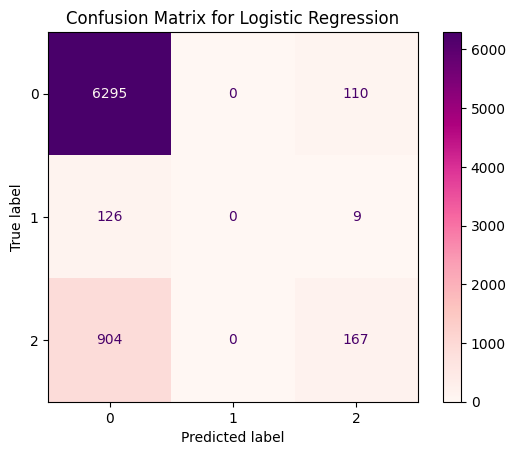

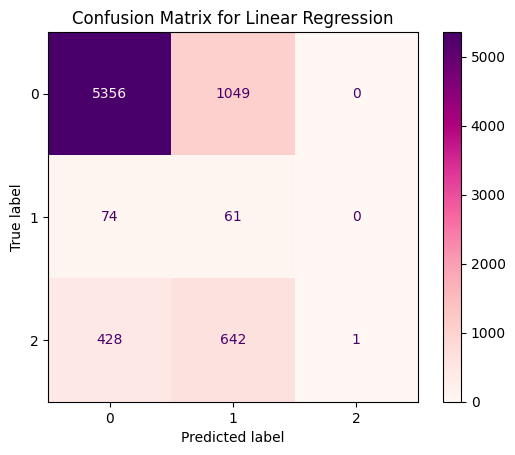

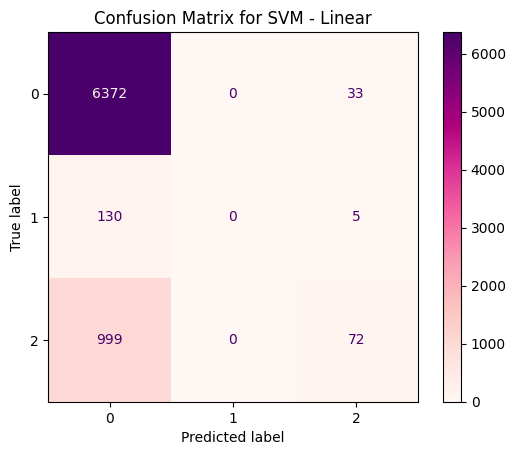

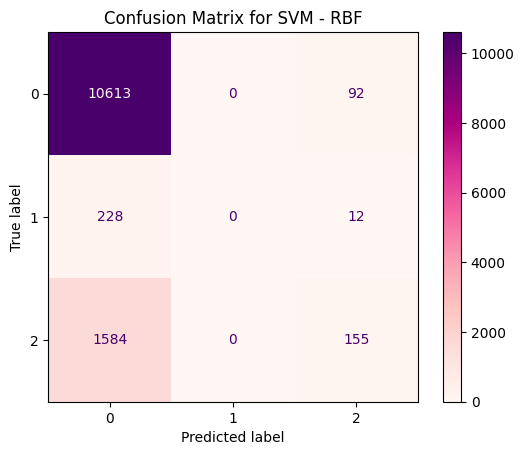

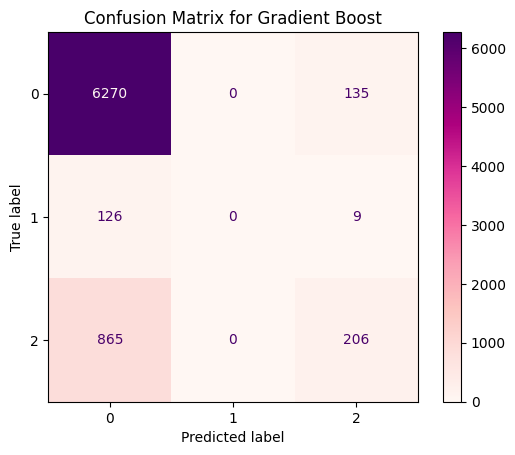

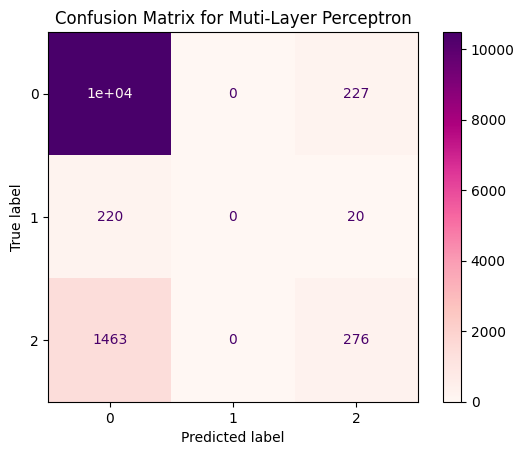

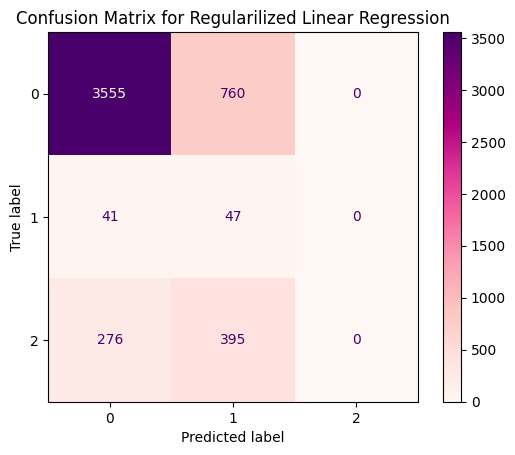

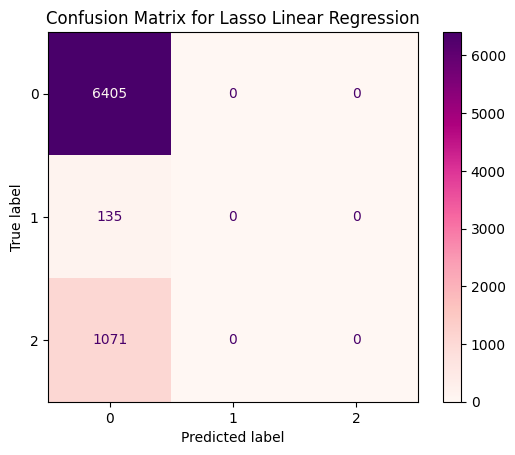

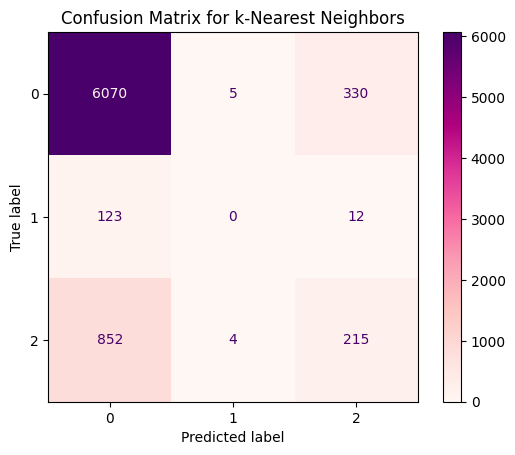

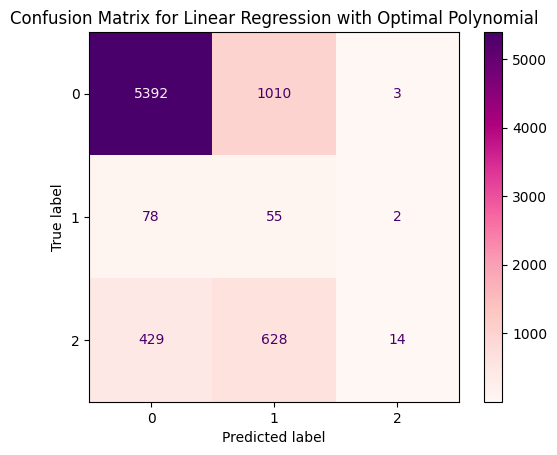

In [44]:
i = 0
best_splits = pd.DataFrame(columns=['model', 
                                    'split', 
                                    'error', 
                                    'generalization',
                                    'true', 
                                    'pred'])
for model in models:
    print(titles[i])
    pipe = make_pipeline(StandardScaler(), model)
    j=0
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sample_df = pd.DataFrame(columns=['accuracy',
                                      'precision', 
                                      'recall', 
                                      'f1-score', 
                                      'error'],
                                      index=index)
    best_df = pd.DataFrame(columns=['model', 
                                    'split', 
                                    'train error', 
                                    'generalization', 
                                    'true', 
                                    'pred'])
    
    for j in range(3): # each sample type
      
      if 'Polynomial' in titles[i]:
        poly_df = pd.DataFrame(columns=['polynomial', 'score'])
        poly = best_poly(train[j][0], train[j][1], test[j][0], test[j][1])       
        pipe = make_pipeline(StandardScaler(),
                             PolynomialFeatures(degree=poly),
                             LinearRegression())
        pipe.fit(train[j][0], train[j][1])
      else:
        pipe.fit(train[j][0], train[j][1])
      print(splits[j])
      # METRICS
      # print(classification_report(y_true=test[j][1], y_pred=pred, zero_division=0))
      if 'Linear Regression' in titles[i]:
        scoring = {'accuracy' : get_acc_score, 
                    'precision' : get_prec_score,
                    'recall' : get_recall_score,
                    'f1_score':get_f1_score,
                    'error' : get_error_score,
                    'gen':get_error_score}
        m = cross_validate(pipe, 
                          train[j][0], 
                          train[j][1],
                          scoring=scoring, 
                          cv=10) 
        pred = pipe.predict(test[j][0])
        test_error = MSE(test[j][1], pred)
        
      else:
        scoring = {'accuracy' : make_scorer(accuracy_score), 
                  'precision' : make_scorer(precision_score, average='weighted', zero_division=0),
                  'recall' : make_scorer(recall_score, average='weighted'),
                  'f1_score':make_scorer(f1_score, average='weighted'),
                  'error': make_scorer(accuracy_score),
                  'gen':make_scorer(accuracy_score)}
        m = cross_validate(pipe, 
                          train[j][0], 
                          train[j][1],
                          scoring=scoring, 
                          cv=10) 
        m['test_error'] = 1-m['test_accuracy'] # validation scores
        pred = pipe.predict(test[j][0])
        test_error = accuracy_score(test[j][1], pred)
        
      sample_df = pd.concat({'accuracy':pd.Series(m['test_accuracy']), 
                             'precision':pd.Series(m['test_precision']),
                             'recall':pd.Series(m['test_recall']),
                             'f1_score':pd.Series(m['test_f1_score']),
                             'error':pd.Series(m['test_error'])},
                              axis=1)
      
      # print(sample_df['error'].min())
      best_df.loc[len(best_df)] = [titles[i], 
                                   splits[j], 
                                   sample_df['error'].min(),
                                   abs(sample_df['error'].min() - test_error),
                                   test[j][1],
                                   pred]
      sample_df = sample_df.style.set_caption(f'Fold Metrics for {titles[i]} with {int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Split')
      sample_df.index = index
      print('\n')
      display(sample_df)
      
      # LEARNING CURVES
      train_scores = get_learning_curve(pipe, train[j][0], train[j][1], titles[i])
      test_scores = get_learning_curve(pipe, test[j][0], test[j][1], titles[i])
      ax.plot(train_scores['percent'], 
              train_scores['scores'], 
              color=train_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Training')
      ax.plot(test_scores['percent'], 
              test_scores['scores'], 
              color=test_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Validation')
      ax.set_xlabel('Sample Size')
      ax.set_ylabel('Score')
      ax.set_title(f'Learning Curve for {titles[i]}')
      ax.legend(loc='best')
      # plt.xlim([0,100])
      # plt.ylim([0.0, 1.05])
      # ax.yaxis.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
      fig.tight_layout(pad=1.5)
      fig.show()

      j += 1

    min = best_df[best_df['generalization'] == best_df['generalization'].min()]
    best_splits = pd.concat([best_splits,min], ignore_index=True)
    # generalization error = diff between error on test and train set
    i+=1  

best_print = best_splits[['model', 'split', 'train error', 'generalization']]
best_print = best_print.rename(columns={'train error':'error'})
best_print.style.set_caption(f'Best Split for Each Model')
display(best_print)
# plt.close()
for b in range(len(best_splits)):
  try:
    ConfusionMatrixDisplay.from_predictions(y_true=best_splits['true'][b], 
                                            y_pred=best_splits['pred'][b],
                                            cmap='RdPu')
    plt.title(f'Confusion Matrix for {titles[b]}')
    plt.show()
  except:
    ConfusionMatrixDisplay.from_predictions(y_true=best_splits['true'][b], 
                                            y_pred=np.round(best_splits['pred'][b]),
                                            cmap='RdPu')
    plt.title(f'Confusion Matrix for {titles[b]}')
    plt.show()##################################################@@@